# How to explore the input space to a generator
Inspired by [this](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/) tutorial by Jason Brownlee.

Generators learn to map points in the space of **random noise** to the space of **images**. We call this random-noise-space the "latent" space, latent meaning "hidden". It's hidden because to us, the noise doesn't have any meaning - it's literally random numbers. It only has meaning to the generator model, which has been trained to create meaning out of these random numbers.


So, what does it mean to "explore" the latent space? It's all about vector arithmetic. If you have two vectors (or points in space) you can draw a line between them, and find the midpoint.

For our generator, those two points in space are two different images. We can "draw a line" between the two images in latent space and find the midpoint. What happens if we now pass the midpoint through the generator? We should get the "average" of the two images!


Let's try it out. First, we'll load up a generator that has already been trained.


In [1]:
%matplotlib inline
from tools import *
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# from https://stackoverflow.com/questions/51512141/how-to-make-matplotlib-saved-gif-looping
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)


In [2]:
noise_size = 100
generator  = Generator(noise_size)
generator_parameters = torch.load('saved_models/pretrained_generator', map_location='cpu')
generator.load_state_dict(generator_parameters['net_state_dict'])
print('Loaded')


Loaded


Next, we'll choose two random points in the latent space to interpolate between.

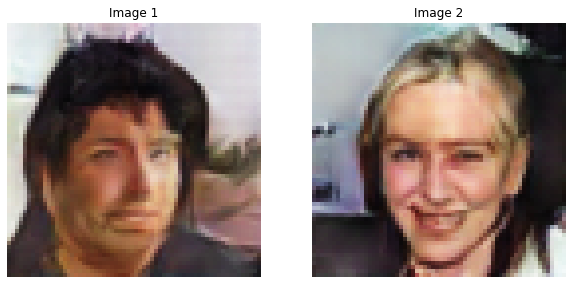

In [10]:
noise1 = torch.randn(1,noise_size,1,1)
noise2 = torch.randn(1,noise_size,1,1)

# Pass noise through generator and visualize the images it creates
image1 = generator(noise1)
image2 = generator(noise2)

fig, ax = plt.subplots(1,2,figsize=(10,5))
for column in range(2):
    ax[column].axis('off')

ax[0].set_title('Image 1')
ax[1].set_title('Image 2')
ax[0].imshow(visualize(image1[0].detach()))
ax[1].imshow(visualize(image2[0].detach()))
plt.show()


### Creating "midway" image

We now have our noise vectors, noise1 and noise2. Let's do the following:

1. Calculate the midway point
2. Pass it through the generator
3. Visualize the result



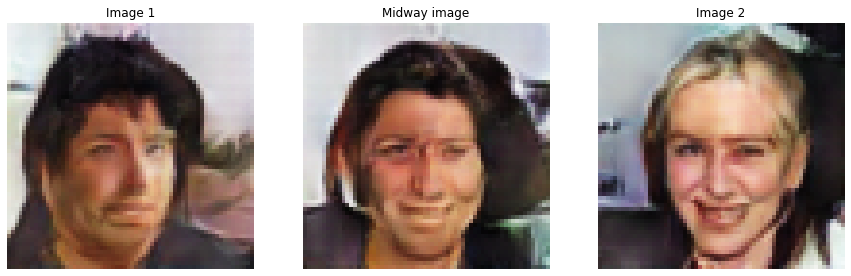

In [11]:
# TODO for students: calculate the midway point
midway_point = 0.5*noise1 + 0.5*noise2

## Alternative calculation with a for loop
# coordinates = []
# for i in range(100):
#     coordinates.append((noise1[i] + noise2[i]) / 2)
# midway_point = torch.Tensor(midway_point)
midway_image = generator(midway_point)


# Plot the images
fig, ax = plt.subplots(1,3,figsize=(15,5))
for column in range(3):
    ax[column].axis('off')

ax[0].set_title('Image 1')
ax[1].set_title('Midway image')
ax[2].set_title('Image 2')

ax[0].imshow(visualize(image1[0].detach()))
ax[1].imshow(visualize(midway_image[0].detach()))
ax[2].imshow(visualize(image2[0].detach()))
plt.show()

Looks cool! (hopefully you are impressed..)


But wait - there is a whole **line** of points between Image 1 and Image 2. Right now, we're only visualizing the middle point. Which brings us to:

### Transitioning smoothly between images

You know how the motion in a video looks like it's smooth, but it's really just a bunch of frames playing one after another? We'll do the same thing here to make a smooth interpolation between Image 1 and 2.

To code this up, we'll define the number of frames we want, calculate each frame, put them into a list, and loop through the list to create a video.

Hint: [This function](https://pytorch.org/docs/master/generated/torch.linspace.html) will be helpful!



In [15]:
num_frames = 20

# Initialize frames to empty list. We'll add on to it each iteration of the loop.
frames = []

fractions = torch.linspace(start=0, end=1, steps=num_frames)
print(fractions)

for i in range(num_frames):
    point = (1-fractions[i])*noise1 + fractions[i]*noise2
    image = generator(point)
    frames.append(image)
    


tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])


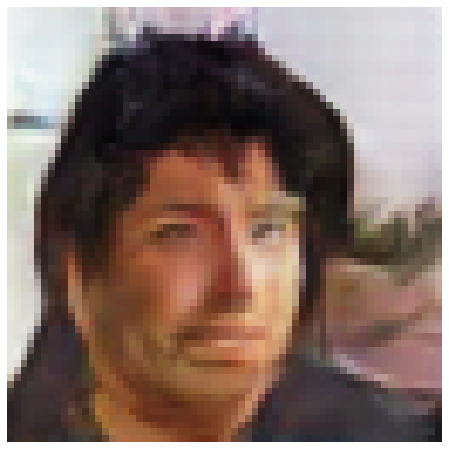

In [16]:
# Visualize progression

# Hack: to make gif go from A -> B -> A,
# add a backwards list to the end of the list
frames_viz = frames + frames[::-1][1:]

# Plot
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(visualize(image[0].detach()), animated=True)] for image in frames_viz]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=0, blit=True)
#ani.save('interpolation.gif', writer=LoopingPillowWriter(fps=20))

HTML(ani.to_jshtml())




## Bonus: Add and subtract features

With vector arithmetic, we can go beyond interpolating between two images. If the generator is trained well, then somewhere in the latent space is the part that means "smiling", or "man", or "has mustache", etc. By adding and subtracting the latent vectors, we can carefully add and subtract these various features from images.

![vector image](resources/latent-image-example.png)

The tricky part with the GAN we've trained is that we can't say "here's an image of a face, find the noise that would generate it". We can only guess-and-check by generating a bunch of noise, seeing what the output images are, and selecting the vectors we want to add and subtract by hand.


In [58]:
num_samples = 100
#noise = torch.randn(num_samples, noise_size,1,1)
noise = torch.load('saved_arrays/noise')

images = []
for i in tqdm(range(num_samples)):
    image = generator(noise[i].unsqueeze(0))
    images.append(generator(noise))
    


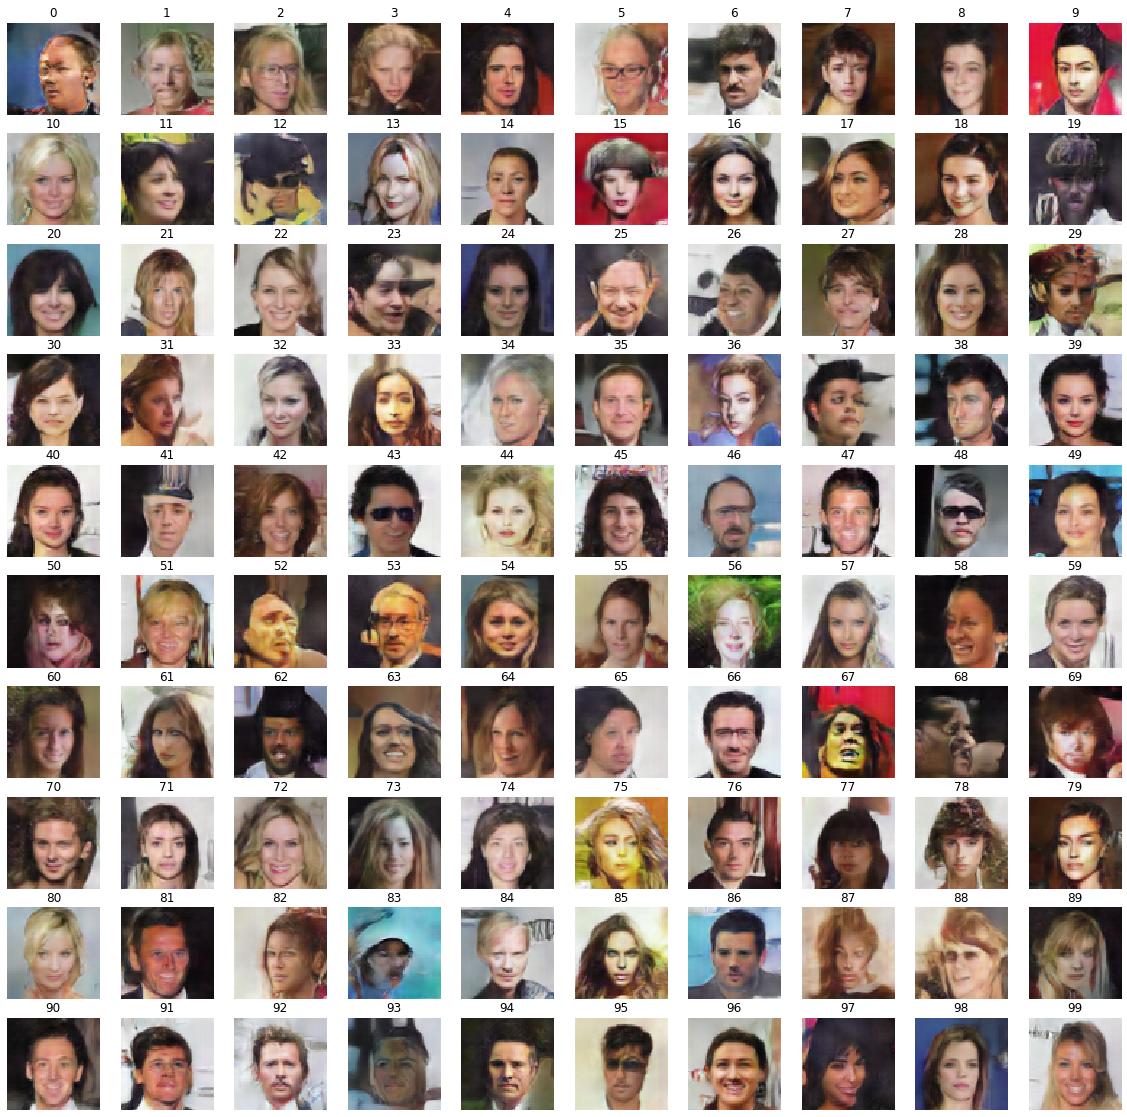

In [59]:


fig, ax = plt.subplots(10,10,figsize=(20,20))
for row in range(10):
    for column in range(10):
        ax[row, column].axis('off')
       
row = 0
column = 0
for i in range(num_samples):
    image = visualize(images[0][i].detach())
    
    ax[row, column].set_title(i)
    ax[row, column].imshow(image)

    column += 1
    if column == 10:
        column = 0
        row += 1
        
plt.show()


In [37]:
# sunglasses_man - smiling_man + smiling_woman = sunglasses_woman?

smiling_woman  = noise[99]
neutral_woman  = noise[98]
neutral_man    = noise[94]

smiling_man = smiling_woman - neutral_woman + neutral_man


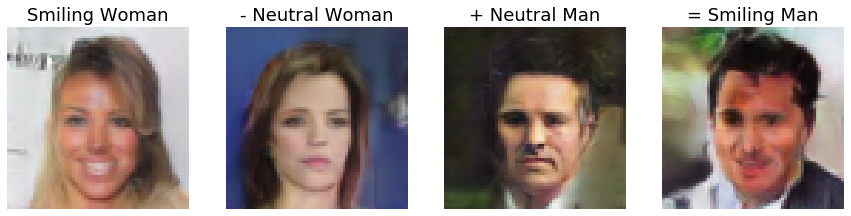

In [57]:
new_image = generator(smiling_man.unsqueeze(0))

# Plot the images
fig, ax = plt.subplots(1,4,figsize=(15,5))
for column in range(4):
    ax[column].axis('off')

ax[0].set_title('Smiling Woman', fontsize=18)
ax[1].set_title('- Neutral Woman', fontsize=18)
ax[2].set_title('+ Neutral Man', fontsize=18)
ax[3].set_title('= Smiling Man', fontsize=18)

ax[0].imshow(visualize(images[0][99].detach()))
ax[1].imshow(visualize(images[0][98].detach()))
ax[2].imshow(visualize(images[0][94].detach()))
ax[3].imshow(visualize(new_image[0].detach()))
#plt.savefig('smiling_man.png')
plt.show()



In [54]:
# torch.save(images, 'saved_arrays/images')
# torch.save(noise, 'saved_arrays/noise')